In [1]:
# Imports

import numpy as np
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [60]:
proj_dir = r"C:\Users\19673418\Desktop\ADA874\Chapter 3"

def save_fig(fig_id, tight_layout = True):
    path = os.path.join(proj_dir, fig_id + ".png")
    print("Saving figure", fig_id, "...")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = 'png', dpi = 300)
    print("Figure saved!")

In [3]:
# Function to sort the MNIST dataset, as fetch_openml returns it unsorted

def sort_by_target(mnist):
    
    # The training and test sets are separately sorted
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    
    # The instances and their labels are sorted so that they still match
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [4]:
# Fetch the MNIST dataset and sort it

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml returns the labels as strings, so we convert them to integers
    sort_by_target(mnist) # The dataset is sorted
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original') # The old function fetch_mldata is used if fetch_openml fails

# The datasets characteristics are shown for inspection
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [5]:
x, y = mnist["data"], mnist["target"]
x.shape

(70000, 784)

In [6]:
y.shape

(70000,)

<function matplotlib.pyplot.show(*args, **kw)>

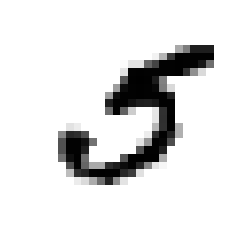

In [7]:
# One of the digits and its label is displayed as an example

some_digit = x[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show

In [8]:
y[36000]

5

In [9]:
# The dataset is split into a training set and test set

x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

In [10]:
# The training set is randomly shuffled

shuffle_index = np.random.permutation(60000)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

In [11]:
# Binary classifier

# Target vectors are defined

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
# Train a SGD classifier

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=5, tol=-np.infty)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
# Check the classifier on the example digit

sgd_clf.predict([some_digit])

array([ True])

In [14]:
# Measure the accuracy of the classifier with cross-validation

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.96295, 0.95065, 0.9665 ])

In [15]:
# Train a classifier to classify every single non-5 image

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    def predict(self, x):
        return np.zeros((len(x), 1), dtype=bool)

In [16]:
# Measure the accuracy of the classifier with cross-validation

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.91055, 0.9107 , 0.9077 ])

In [17]:
# Obtain predictions from cross-validation

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

In [18]:
# Obtain confusion matrix

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53507,  1072],
       [ 1326,  4095]], dtype=int64)

In [19]:
# Obtain confusion matrix for a perfect classifier

y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [20]:
# Compute precision, recall and the F1 score

from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(y_train_5, y_train_pred)

0.7925295142248887

In [21]:
recall_score(y_train_5, y_train_pred)

0.7553956834532374

In [22]:
f1_score(y_train_5, y_train_pred)

0.7735171892708728

In [23]:
# Change the threshold and observe results

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([17678.08903727])

In [24]:
# Set a low threshold and check the example digit

threshold = 0

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
# Set a high threshold and check the example digit

threshold = 200000

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [26]:
# Obtain decision scores from cross-validation

y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method="decision_function")

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [28]:
y_scores.shape

(60000,)

In [29]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

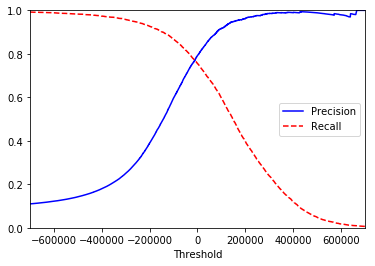

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision")
    plt.plot(thresholds, recalls[:-1], "r--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center right")
    plt.ylim([0,1])
    plt.xlim([-700000, 700000])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

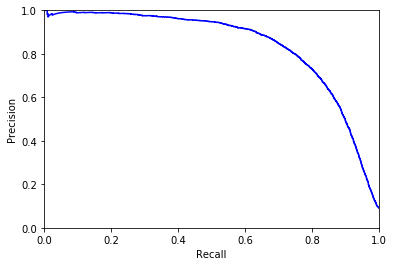

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])

plot_precision_vs_recall(precisions, recalls)
plt.show()

In [32]:
y_train_pred_90 = (y_scores > 70000)

precision_score(y_train_5, y_train_pred_90)

0.8868823676950088

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.6522781774580336

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

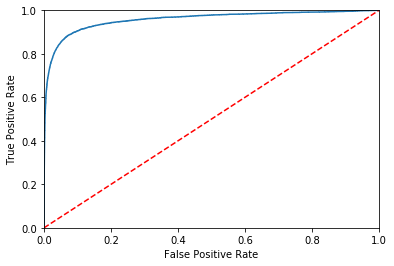

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0,1], [0,1], 'r--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9581124195350476

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method="predict_proba")

In [38]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

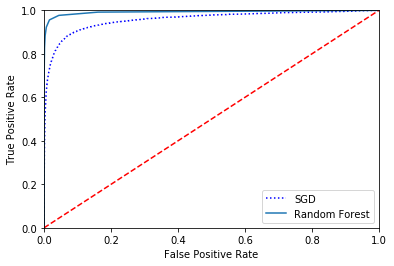

In [39]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9922756373120514

In [41]:
y_train_pred_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3)

precision_score(y_train_5, y_train_pred_forest)

0.9840087623220153

In [42]:
recall_score(y_train_5, y_train_pred_forest)

0.8286294041689725

In [43]:
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [44]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -195869.70686402,  -388476.0321498 ,  -394306.1460436 ,
          -89275.67904801,  -396509.283252  ,    17678.08903727,
        -1023429.9439889 ,  -242748.43967554,  -713840.08115491,
         -321471.60669655]])

In [45]:
np.argmax(some_digit_scores)

5

In [46]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [47]:
sgd_clf.classes_[5]

5

In [48]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=5, tol=-np.infty))
ovo_clf.fit(x_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [49]:
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [50]:
len(ovo_clf.estimators_)

45

In [51]:
forest_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [52]:
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [53]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0.1, 0. ]])

In [54]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.87287542, 0.88139407, 0.82937441])

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))

cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90946811, 0.91344567, 0.90678602])

In [56]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5729,    2,   25,   13,   11,   51,   38,   11,   41,    2],
       [   1, 6475,   51,   26,    6,   37,    7,    9,  119,   11],
       [  54,   36, 5346,   93,   76,   23,   96,   59,  159,   16],
       [  51,   40,  135, 5338,    3,  230,   35,   55,  147,   97],
       [  22,   29,   38,    9, 5357,   10,   57,   30,   78,  212],
       [  70,   38,   31,  196,   71, 4592,  108,   29,  187,   99],
       [  38,   22,   40,    2,   42,   95, 5629,    7,   43,    0],
       [  22,   20,   72,   28,   50,   10,    5, 5808,   18,  232],
       [  54,  145,   72,  142,   14,  166,   56,   27, 5041,  134],
       [  40,   36,   33,   86,  152,   38,    3,  200,   82, 5279]],
      dtype=int64)

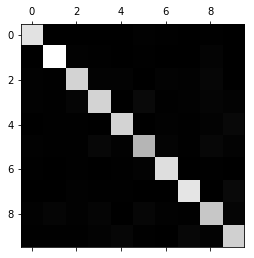

In [57]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [58]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure ConfusionMatrixAltered ...
Figure saved!


<Figure size 720x720 with 0 Axes>

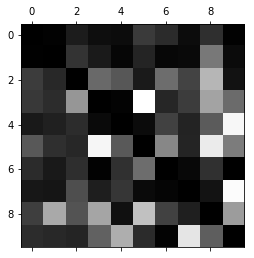

In [61]:
plt.figure(figsize = (10, 10))
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("ConfusionMatrixAltered")
plt.show()

In [62]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Saving figure 3and5 ...
Figure saved!


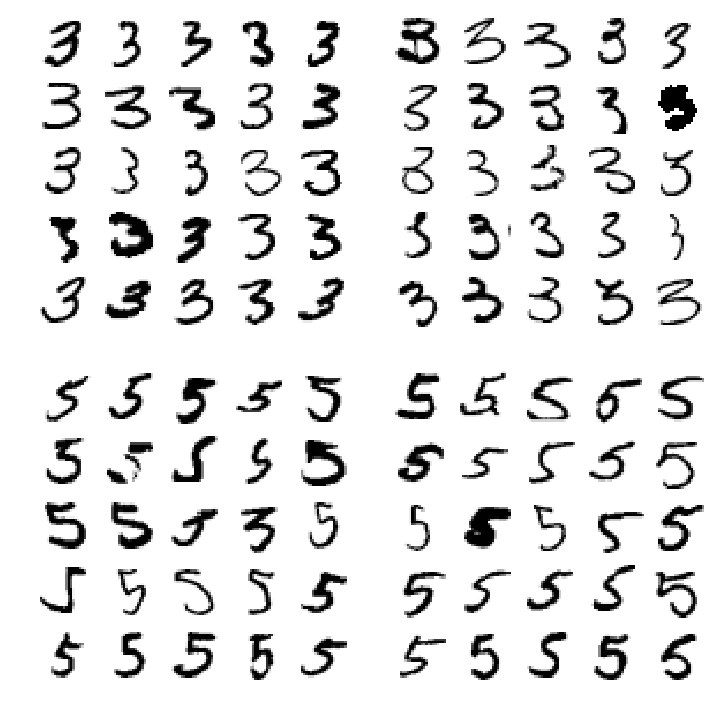

In [63]:
cl_a, cl_b = 3, 5
x_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
x_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
x_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
x_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize = (10, 10))
plt.subplot(221); plot_digits(x_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(x_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(x_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(x_bb[:25], images_per_row=5)
save_fig("3and5")
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

In [ ]:
noise = rnd.randint(0, 100, (len(x_train), 784))
noise = rnd.randint(0, 100, (len(x_test), 784))
x_train_mod = x_train + noise
x_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

In [ ]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict([x_test_mod[some_index]])
plot_digit(clean_digit)